## Applying new SRB calculations on data

In [1]:
# data loading
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from mpl_toolkits.mplot3d import Axes3D
from scipy import stats, integrate

%matplotlib inline
sns.set(color_codes=True)

path = '../datasets/preprocessed/'
dfrat     = pd.read_hdf(path+'relationalDatabase.h5', 'Rat_Behavior').set_index('index')
dfevent   = pd.read_hdf(path+'relationalDatabase.h5', 'Events').set_index('index')
dfsession = pd.read_hdf(path+'relationalDatabase.h5', 'Sessions')

dfratclean = pd.read_hdf(path+'filteredDatabase.h5', 'Rat_Behavior').set_index('index')
dfratv = pd.read_hdf(path+'velocityDatabase.h5', 'Rat_Behavior').set_index('index')

In [4]:
df = pd.merge(dfratv, dfevent, on=['Frame', 'session_id','Time'])

In [2]:
limits=pd.DataFrame({'speed':[7, -7, 14, -14, 28, -28],
                     'min'  :[-10, 3, -16, 6, -34, 20],
                     'max'  :[-3, 10, -6, 16, -20, 34]})
limits

,max,min,speed
0,-3,-10,7
1,10,3,-7
2,-6,-16,14
3,16,6,-14
4,-20,-34,28
5,34,20,-28


In [5]:
df['limmin'], df['limmax'] = 0, 0
for index, row in limits.iterrows():
    df['changemin'] = (df['limmin']==0) & (df['speed']==-row['speed'])
    df['changemax'] = (df['limmax']==0) & (df['speed']==-row['speed'])
    df['limmin'] = np.where(df['changemin']==True, row['min'], df['limmin'])
    df['limmax'] = np.where(df['changemax']==True, row['max'], df['limmax'])

In [6]:
df['SRB'] = (df['U'] > df['limmin']) & (df['U'] < df['limmax'])
print(len(df))
print(len(df[df['SRB']==True]))

761985
110056


## Removing small SRB moments

In [7]:
# MERGING SRB THAT HAVE REALLY SHORT BREAKS
DF2 = pd.DataFrame()
for name, dd in df.groupby('session_id'):   
    # calculating dtime - time difference between srb    
    dfSRBtemp = dd[dd['SRB']==True]
    dfSRBtemp['dtime'] = dfSRBtemp['Time'].diff(1)
    df2 = pd.merge(dd, dfSRBtemp[['dtime', 'Frame', 'session_id','Time']], on=['Frame', 'session_id','Time'], how='outer')
    df2.fillna(0, inplace=True)
    
    #special time cases
    dftemp = dfSRBtemp[(dfSRBtemp['dtime']>0.005) & (dfSRBtemp['dtime']<0.1)]
    dftemp = dftemp.reset_index(drop=True)

    maxF, minF = {}, {}
    minF={}
    df2['SRBall'] = df2['SRB']     
    df2['SRBtt'] = False
    # merge super close events
    for i in np.arange(0,len(dftemp)):
        maxF[i] = dftemp.Time[i]
        minF[i] = maxF[i]-dftemp.dtime[i]
    
        df2['SRBtt'] = (df2['Time']>minF[i]) & (df2['Time']<maxF[i])
        df2['SRBall'] = (df2['SRBtt']==True) | (df2['SRBall']==True)
        
    df2['dtimeA'] = df2['dtime']
    df2.drop('dtime', inplace=True, axis=1)
    
    
    # DELETING SHORT SRB
    # calculating dtime - time of srb    
    dfSRBtemp2 = df2[df2['SRBall']==False]
    dfSRBtemp2['dtime'] = dfSRBtemp2['Time'].diff(1)
    df22 = pd.merge(df2, dfSRBtemp2[['dtime', 'Frame', 'session_id','Time']], on=['Frame', 'session_id','Time'], how='outer')
    df22.fillna(0, inplace=True)
    
    #special time cases
    dftemp2 = dfSRBtemp2[(dfSRBtemp2['dtime']<0.1) & (dfSRBtemp2['dtime']>0.0049)]
    dftemp2 = dftemp2.reset_index(drop=True)    
    maxF2, minF2 = {}, {}
    df22['SRBall2'] = df22['SRBall']     
    df22['SRBtt2'] = False
    
    # delete short events
    for i in np.arange(0,len(dftemp2)):
        maxF2[i] = dftemp2.Time[i]
        minF2[i] = dftemp2.Time[i] - dftemp2.dtime[i]
        df22['SRBtt2'] = ((df22['Time']>=minF2[i]) & (df22['Time']<=maxF2[i]))# | (df2['SRBtt']==True)
        df22['SRBall2'] = (df22['SRBtt2']==False) & (df22['SRBall2'] == True)
        
    DF2 = pd.concat([DF2, df22], axis=0, ignore_index=True)    

/home/ateska/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/home/ateska/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


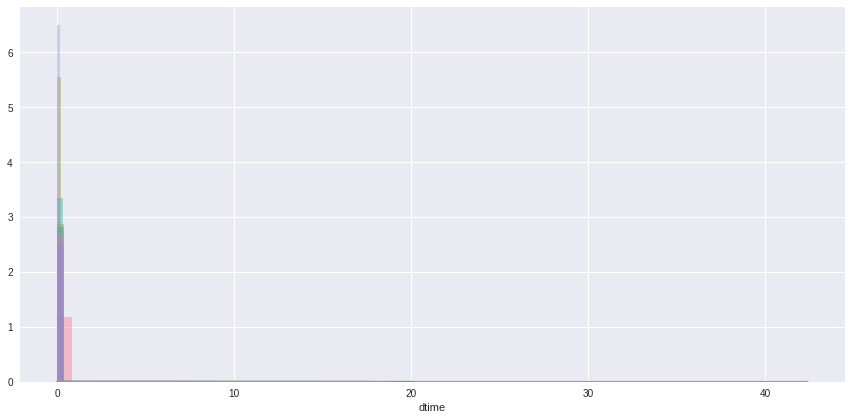

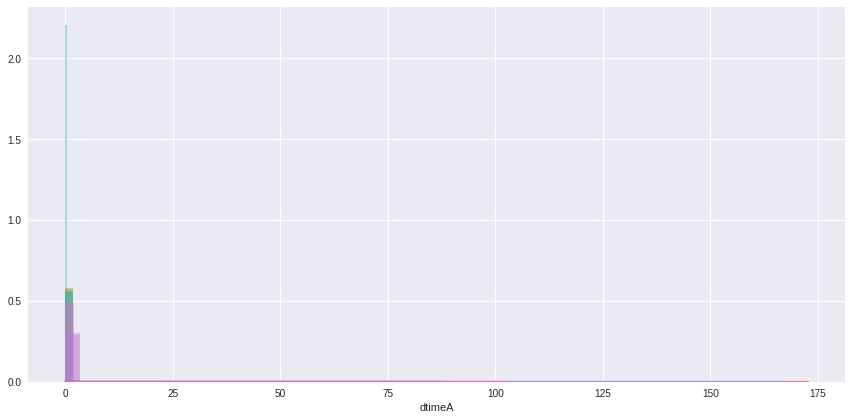

In [10]:
g = sns.FacetGrid(data=DF2, size=6, aspect=2, hue='session_id')#, xlim=[0,10])
g.map(sns.distplot, 'dtime')

g = sns.FacetGrid(data=DF2, size=6, aspect=2, hue='session_id')#, xlim=[0,1])
g.map(sns.distplot, 'dtimeA')
